# Setup

In [102]:
import sys
sys.path.append('..')

import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


import model
from utils.data_utils import Season
from utils.model_utils import Feature
from data.footystats import GenerateDataFrame
from pipeline.X_table_constructor import XTrainConstructor, XTestConstructor

import shap
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression



In [103]:
df_past1 = GenerateDataFrame(season=Season.Past1).load()
df_past2 = GenerateDataFrame(season=Season.Past2).load()
df_past5 = GenerateDataFrame(season=Season.Past5).load()
df_past10 = GenerateDataFrame(season=Season.Past10).load()

In [104]:
df_past10.describe().to_csv('past10.csv')

# Preliminary Training

In [105]:
datasets = {
    "P1": df_past1,
    "P2": df_past2,
    "P5": df_past5,
    "P10": df_past10
}

full_feature_params = {
    Feature.GOAL_STATS.value: True,
    Feature.SHOOTING_STATS.value: True,
    Feature.POSSESSION_STATS.value: True,
    Feature.ODDS.value: True,
    Feature.XG.value: True,
    Feature.HOME_AWAY_RESULTS.value: True,
    Feature.CONCEDED_STATS.value: True,
    Feature.LAST_N_MATCHES.value: True,
    Feature.WIN_STREAK.value: True,
}

team_performance_feature_params = {
    Feature.GOAL_STATS.value: True,
    Feature.SHOOTING_STATS.value: True,
    Feature.POSSESSION_STATS.value: True,
    Feature.HOME_AWAY_RESULTS.value: True,
    Feature.CONCEDED_STATS.value: True,
}

In [106]:
models = {
    "LR": (team_performance_feature_params, LogisticRegression(max_iter=1000)),
    "XGB": (full_feature_params, xgb.XGBClassifier(objective="multi:softmax", num_class=3)),
    "SVM": (full_feature_params, SVC(kernel='rbf', C=1, gamma=0.1)),
    "RFC": (full_feature_params, RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)),
    "MLP": (full_feature_params, MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))
}

In [107]:
# initalise a dict of dicts to store the results for each dataset and model
metrics = ["Accuracy", "F1", "Precision", "Recall", "CrossVal"]
results = { metric: { dataset: { model_name: 0 for model_name in models.keys() } for dataset in datasets.keys() } for metric in metrics }

## Training and Plotting

In [108]:
accuracy_results = { dataset: { model_name: 0 for model_name in models.keys() } for dataset in datasets.keys() }

for dataset_name, df in datasets.items():
    train, test, unique_teams = model.pre_process_data(df)
    X_train_all, y_train, X_test_all, y_test = model.feature_engineering(train, test, unique_teams, full_feature_params)
    X_train_team_performance, _, X_test_team_performance, _ = model.feature_engineering(train, test, unique_teams, team_performance_feature_params)

    for model_name, (feature_params, ml_model) in models.items():
        if model_name == "BENCH":
            X_train, X_test = X_train_team_performance.copy(), X_test_team_performance.copy()
        else:
            X_train, X_test = X_train_all.copy(), X_test_all.copy()

        ml_model.fit(X_train, y_train)
        y_pred = ml_model.predict(X_test)

        results["Accuracy"][dataset_name][model_name] = accuracy_score(y_test, y_pred)
        results["F1"][dataset_name][model_name] = f1_score(y_test, y_pred, average='weighted')
        results["Precision"][dataset_name][model_name] = precision_score(y_test, y_pred, average='weighted')
        results["Recall"][dataset_name][model_name] = recall_score(y_test, y_pred, average='weighted')
        results["CrossVal"][dataset_name][model_name] = cross_val_score(ml_model, X_train, y_train, cv=5, scoring='accuracy').mean()


/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

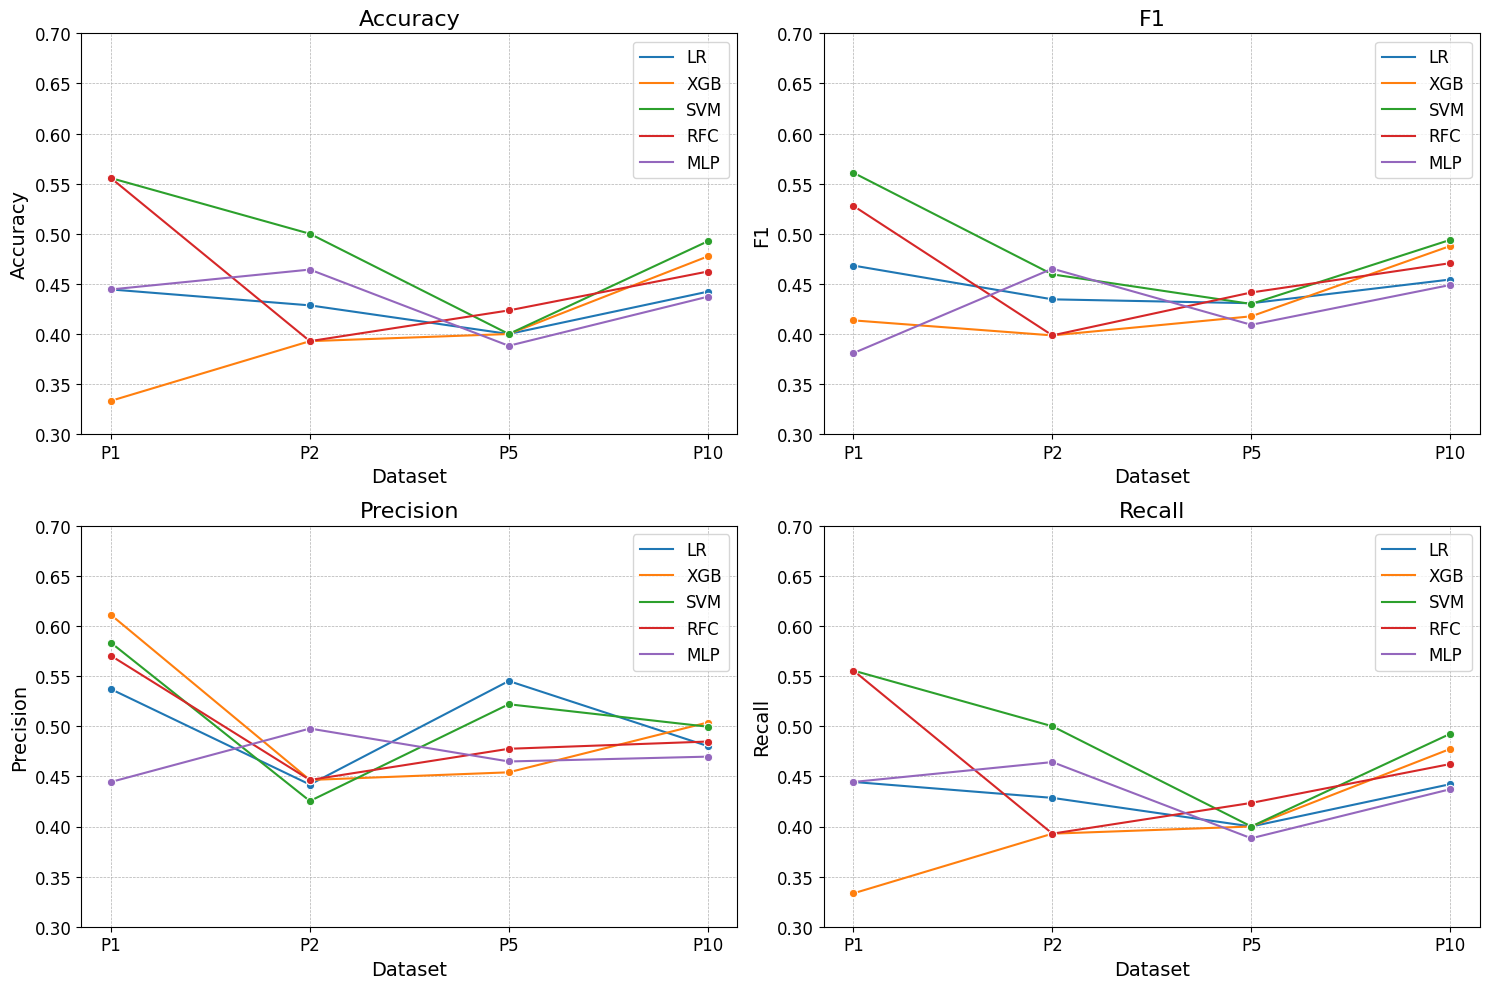

In [109]:
# Plot the results as line graphs
plt.figure(figsize=(15, 10))

for i, metric, result in zip(range(4), metrics, [results["Accuracy"], results["F1"], results["Precision"], results["Recall"]]):
    df = pd.DataFrame(result)
    df = df.T.reset_index().rename(columns={"index": "Dataset"})
    df = df.melt(id_vars=["Dataset"], var_name="Model", value_name=metric)

    plt.subplot(2, 2, i+1)
    sns.lineplot(x="Dataset", y=metric, hue="Model", data=df, marker="o")

    plt.title(metric, fontsize=16)
    plt.legend(fontsize='large')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Dataset", fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.ylim(0.3, 0.7)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("fb_prem_model_results.pdf")
plt.show()


# Feature Selection

<Figure size 1000x800 with 0 Axes>

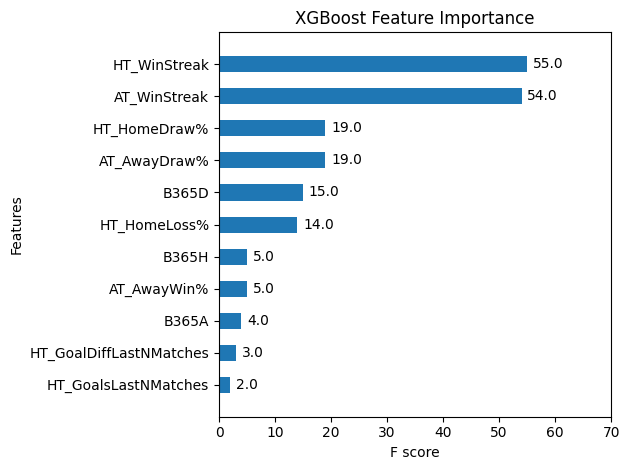

In [110]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Train a model (e.g., XGBoost)
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=3)
xgb_model.fit(X_train, y_train)

# Plot feature importance for the next 10 features (ranks 11-20)
plt.figure(figsize=(10, 8))

# First, get the importance scores
importance_scores = xgb_model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)

# Select features ranked 11 to 20
features_11_20 = dict(sorted_importance[10:20])

# Plotting only the selected features
plot_importance(xgb_model, importance_type='weight', max_num_features=None, 
                height=0.5, grid=False)

# Limit the x-axis
plt.xlim(0, 70)

# Title for the next 10 features
plt.title('XGBoost Feature Importance')

# Adjust layout for better fit
plt.tight_layout()

plt.show()


# Optimised Retraining

In [111]:
datasets = {
    "P1": df_past1,
    "P2": df_past2,
    "P5": df_past5,
    "P10": df_past10
}

shap_feature_params = {
    Feature.GOAL_STATS.value: True,
    Feature.ODDS.value: True,
    Feature.LAST_N_MATCHES.value: True,

}

In [119]:
models = {
    "LR": (shap_feature_params, LogisticRegression(max_iter=1000)),
    "XGB": (shap_feature_params, xgb.XGBClassifier(objective="multi:softmax", num_class=3)),
    "SVM": (shap_feature_params, SVC(kernel='rbf', C=1, gamma=0.1)),
    "RFC": (shap_feature_params, RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)),
    "MLP": (shap_feature_params, MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))
}

In [120]:
# initalise a dict of dicts to store the results for each dataset and model
metrics = ["Accuracy", "F1", "Precision", "Recall", "CrossVal"]
results = { metric: { dataset: { model_name: 0 for model_name in models.keys() } for dataset in datasets.keys() } for metric in metrics }

In [121]:
accuracy_results = { dataset: { model_name: 0 for model_name in models.keys() } for dataset in datasets.keys() }

for dataset_name, df in datasets.items():
    train, test, unique_teams = model.pre_process_data(df)
    X_train_all, y_train, X_test_all, y_test = model.feature_engineering(train, test, unique_teams, shap_feature_params)
    X_train_team_performance, _, X_test_team_performance, _ = model.feature_engineering(train, test, unique_teams, team_performance_feature_params)

    for model_name, (feature_params, ml_model) in models.items():
        if model_name == "BENCH":
            X_train, X_test = X_train_team_performance.copy(), X_test_team_performance.copy()
        else:
            X_train, X_test = X_train_all.copy(), X_test_all.copy()

        ml_model.fit(X_train, y_train)
        y_pred = ml_model.predict(X_test)

        results["Accuracy"][dataset_name][model_name] = accuracy_score(y_test, y_pred)
        results["F1"][dataset_name][model_name] = f1_score(y_test, y_pred, average='weighted')
        results["Precision"][dataset_name][model_name] = precision_score(y_test, y_pred, average='weighted')
        results["Recall"][dataset_name][model_name] = recall_score(y_test, y_pred, average='weighted')
        results["CrossVal"][dataset_name][model_name] = cross_val_score(ml_model, X_train, y_train, cv=5, scoring='accuracy').mean()


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: Convergen

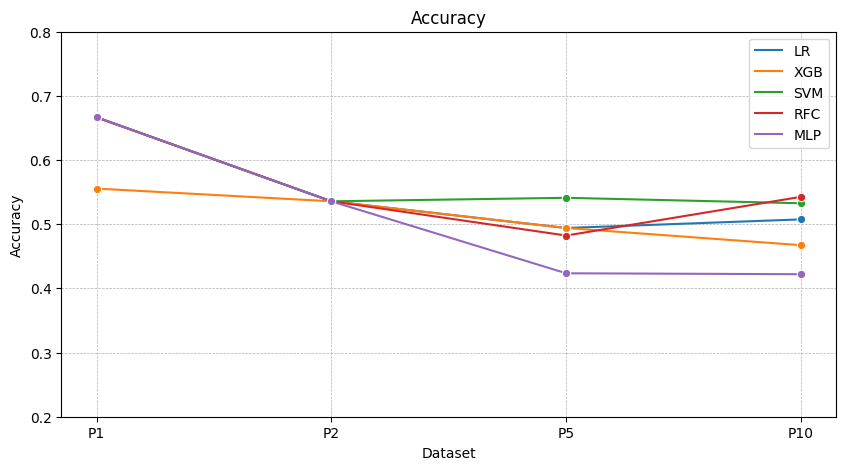

In [122]:
# Plot accuracy results on a line chart
plt.figure(figsize=(10, 5))
df = pd.DataFrame(results["Accuracy"])
df = df.T.reset_index().rename(columns={"index": "Dataset"})
df = df.melt(id_vars=["Dataset"], var_name="Model", value_name="Accuracy")

sns.set_palette("tab10")
sns.lineplot(x="Dataset", y="Accuracy", hue="Model", data=df, marker="o")
plt.title("Accuracy")
plt.legend(fontsize='medium')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0.2, .8)
plt.savefig("accuracy_results.pdf")
plt.show()

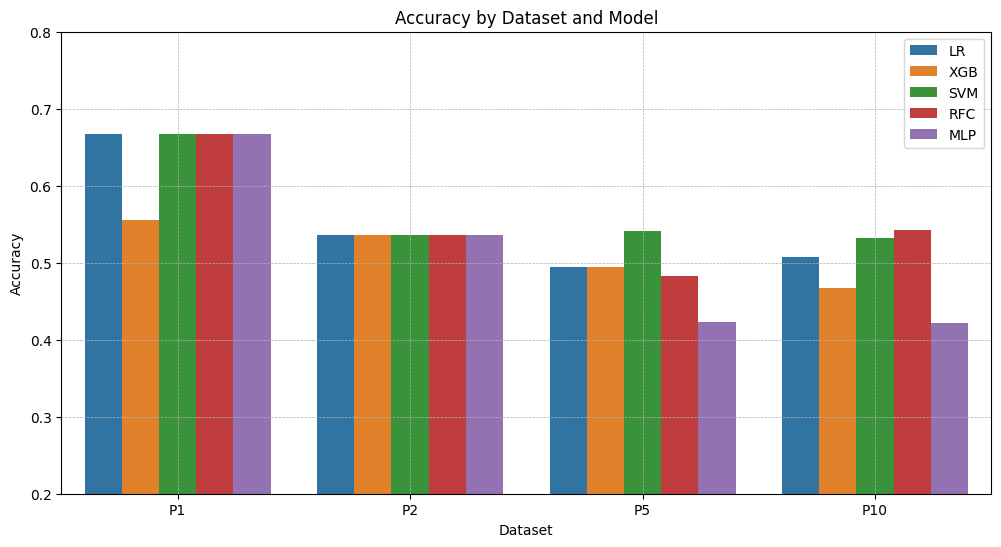

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming `results` is a dictionary containing accuracy results
# Convert the accuracy results to a DataFrame
df = pd.DataFrame(results["Accuracy"])
df = df.T.reset_index().rename(columns={"index": "Dataset"})
df = df.melt(id_vars=["Dataset"], var_name="Model", value_name="Accuracy")

# Plot accuracy results on a bar chart
plt.figure(figsize=(12, 6))
sns.set_palette("tab10")

# Create a barplot
sns.barplot(x="Dataset", y="Accuracy", hue="Model", data=df)

# Add title and labels
plt.title("Accuracy by Dataset and Model")
plt.legend(fontsize='medium')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0.2, .8)

# Save the figure
plt.savefig("accuracy_results.pdf")

# Show the plot
plt.show()


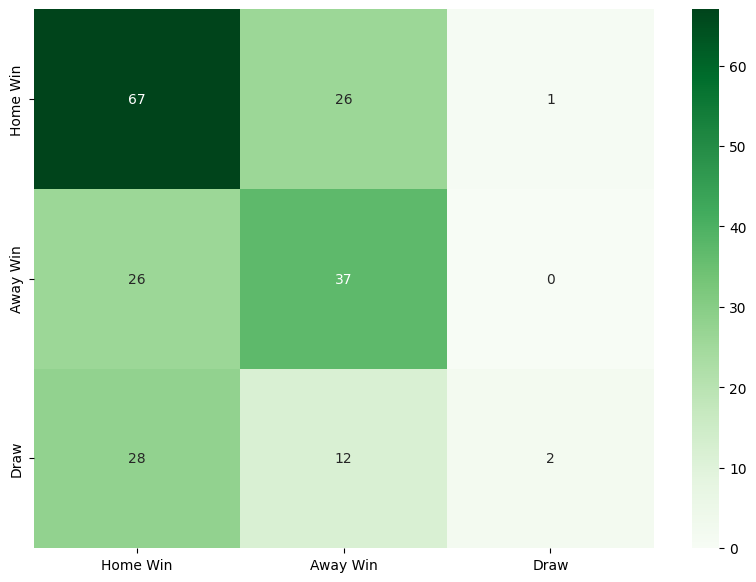

In [133]:
train, test, unique_teams = model.pre_process_data(datasets["P10"])
X_train, y_train, X_test, y_test = model.feature_engineering(train, test, unique_teams, shap_feature_params)

rfc_model = SVC(kernel='rbf', C=1, gamma=0.1)
rfc_model.fit(X_train, y_train)

y_pred = rfc_model.predict(X_test)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=["Home Win", "Away Win", "Draw"], yticklabels=["Home Win", "Away Win", "Draw"], cmap='Greens')
plt.savefig("fb_confusion_matrix.pdf")
plt.show()

In [124]:
col1 = results["CrossVal"]
col2 = results["Accuracy"]
col3 = results["F1"]
col4 = results["Precision"]
col5 = results["Recall"]

df1 = pd.DataFrame(col1).round(2)
df2 = pd.DataFrame(col2).round(2)
df3 = pd.DataFrame(col3).round(2)
df4 = pd.DataFrame(col4).round(2)
df5 = pd.DataFrame(col5).round(2)

df1 = df1.T.reset_index().rename(columns={"index": "Dataset"})
df1 = df1.melt(id_vars=["Dataset"], var_name="Model", value_name="CrossVal")

df2 = df2.T.reset_index().rename(columns={"index": "Dataset"})
df2 = df2.melt(id_vars=["Dataset"], var_name="Model", value_name="Accuracy")

df3 = df3.T.reset_index().rename(columns={"index": "Dataset"})
df3 = df3.melt(id_vars=["Dataset"], var_name="Model", value_name="F1")

df4 = df4.T.reset_index().rename(columns={"index": "Dataset"})
df4 = df4.melt(id_vars=["Dataset"], var_name="Model", value_name="Precision")

df5 = df5.T.reset_index().rename(columns={"index": "Dataset"})
df5 = df5.melt(id_vars=["Dataset"], var_name="Model", value_name="Recall")

df = pd.merge(df1, df2, on=["Dataset", "Model"])
df = pd.merge(df, df3, on=["Dataset", "Model"])
df = pd.merge(df, df4, on=["Dataset", "Model"])
df = pd.merge(df, df5, on=["Dataset", "Model"])

row_order_1 = ["LR", "XGB", "SVM", "RFC", "MLP"]
row_order_2 = ["P10", "P5", "P2", "P1"]

df["Model"] = pd.Categorical(df["Model"], categories=row_order_1, ordered=True)
df["Dataset"] = pd.Categorical(df["Dataset"], categories=row_order_2, ordered=True)

column_order = ["Model", "Dataset", "Accuracy", "F1", "Precision", "Recall", "CrossVal"]
df = df[column_order]

df.to_csv("fb_results.csv", index=False)

In [126]:
df['Accuracy'].mean()

0.5415000000000001

In [130]:
df[df['Dataset']== 'P10']['Accuracy'].mean()

0.49399999999999994